In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA

print("Todos los paquetes necesarios han sido importados")

data_sp = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_LIT7_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])


Todos los paquetes necesarios han sido importados


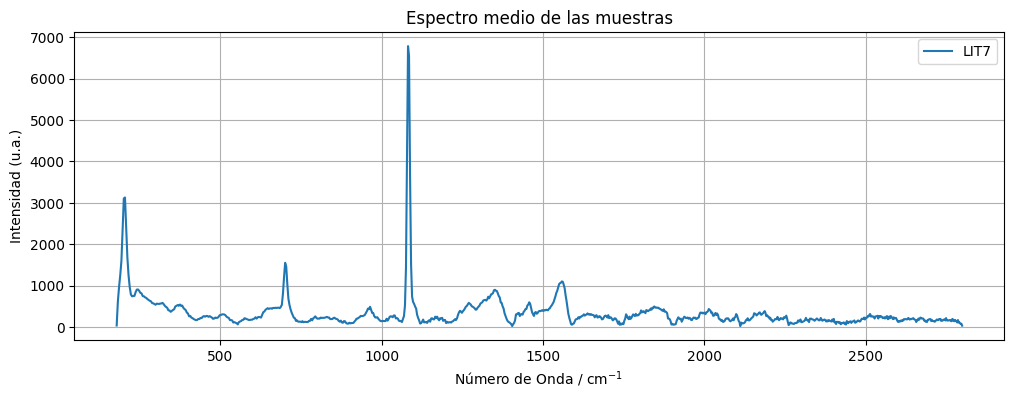

In [4]:
def avg_spectrum (data, muestras, titulo = "Espectro medio de las muestras"):

  plt.figure(figsize=(12, 4))

  for i, muestra in enumerate(muestras):
    data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
    wavenumber = data_muestra.columns.get_level_values(0).astype(float)
    # Calculamos las intensidades medias para cada numero de onda
    mean_intensity = data_muestra.mean(axis=0)

    # Representa el espectro medio con el color correspondiente
    plt.plot(wavenumber, mean_intensity, label=f'{muestra}')

  # Etiquetas y título para el gráfico
  plt.xlabel("Número de Onda / cm$^{-1}$ ")
  plt.ylabel('Intensidad (u.a.)')
  plt.title(f'{titulo}')

  plt.legend()
  plt.grid(True)


  plt.show()

avg_spectrum(data_sp, ['LIT7'])

In [5]:
# Desactiva las advertencias de SettingWithCopyWarning
warnings.filterwarnings("ignore")

# Medimos el tiempo
t1 = time.time()

data = data_sp.copy()

# Número de clústers. En este caso podemos diferenciar tres colores: blanco, amarillo y rojo.
n_clusters=3

## Clustering utilizando KMeans
# Lo aplicamos para las columnas seleccionadas (los números de ondas que nos interesan)
kmeans = KMeans(n_clusters=n_clusters, random_state= 50).fit(data)
centroides_var = kmeans.cluster_centers_
# Asignamos los clusters y lo guardamos en el df
data["Cluster_KMeans"] = kmeans.labels_

## Clustering Agglomerative
# Para probar el siguiente método es necesario coger únicamente los espectros, por lo que utilizamos todos los datos menos
# la última columna
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
# Ajustar el modelo a tus datos
data["Cluster_Agglomerative"] = agg_clustering.fit_predict(data.iloc[:, :-1])

## Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state= 50)
data["Cluster_Spectral"] = spectral_clustering.fit_predict(data.iloc[:, :-2]) 

birch_clustering = Birch(threshold=0.01, n_clusters= n_clusters)
data["Cluster_Birch"] = birch_clustering.fit_predict(data.iloc[:, :-3]) 
t2 = time.time()

print(f"Se ha terminado el proceso en {round(t2-t1,2)} s")


Se ha terminado el proceso en 9.81 s


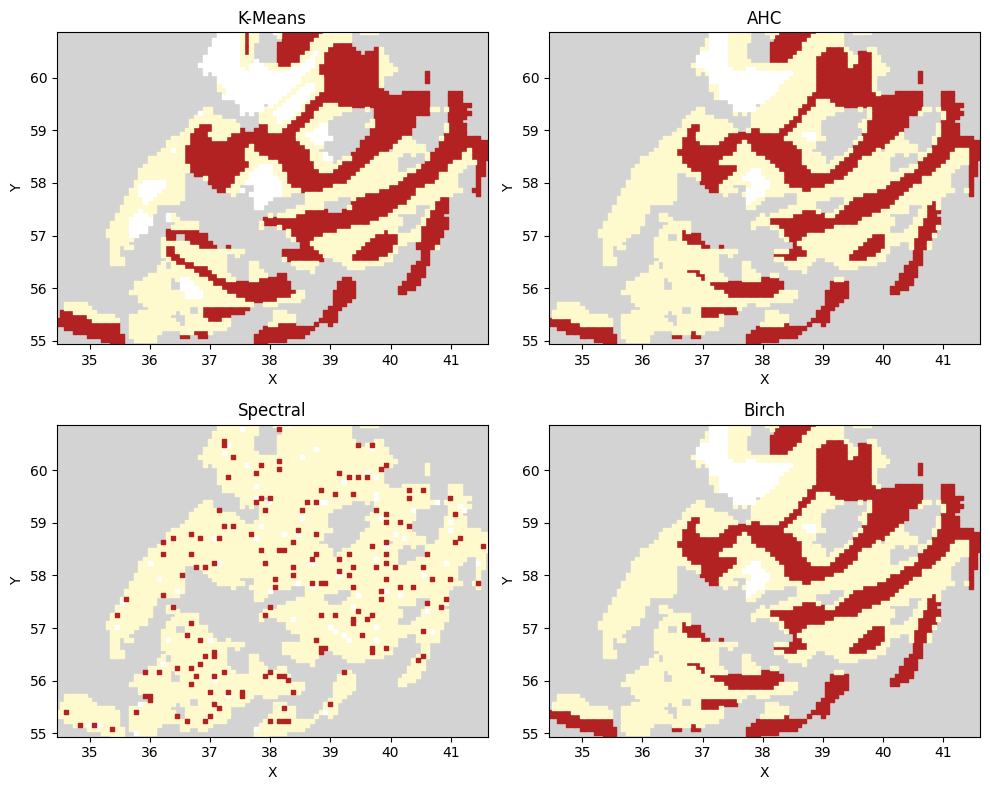

In [14]:
def plot_clusters_SP(data, titulo = "Distribución de Clústers para diferentes Métodos"):
    
  # Lista de tipos de clustering 
  clusters_names = ["Cluster_KMeans", "Cluster_Agglomerative","Cluster_Spectral", "Cluster_Birch" ] 
  cluster_title =["K-Means", "AHC","Spectral", "Birch" ]

  # Defino los colores para cada tipo de clustering

  cluster_colors_kmeans = {0: "lemonchiffon", 1: "firebrick", 2: "white"} 
  cluster_colors_agglomerative = {0: "lemonchiffon", 1: "firebrick", 2: "white"} 
  cluster_colors_spectral = {0: "lemonchiffon", 1: "white", 2: "firebrick"}  
  cluster_colors_birch = {0: "lemonchiffon", 1: "firebrick", 2: "white"}  


  # Crea una figura con subplots en una fila y tres columnas
  fig, axs = plt.subplots(2, 2, figsize=(10, 8))

  # Obtengo los datos X e Y para representar los espectros de la muestra
  data["X"] = data.index.get_level_values("X")
  data["Y"] = data.index.get_level_values("Y")

  # Para cada tipo de clustering, crea un subplot
  for i, cluster_column in enumerate(clusters_names):
      axs[i // 2, i % 2].set_facecolor("lightgray")
      for cluster in data[cluster_column].unique():
          subset = data[data[cluster_column] == cluster]
          if cluster_column == "Cluster_KMeans":
              axs[i // 2, i % 2].scatter(subset["X"], subset["Y"], marker=",", color=cluster_colors_kmeans[cluster], s=12)
          elif cluster_column == "Cluster_Agglomerative":
              axs[i // 2, i % 2].scatter(subset["X"], subset["Y"], marker=",", color=cluster_colors_agglomerative[cluster], s=12)
          elif cluster_column == "Cluster_Birch":
              axs[i // 2, i % 2].scatter(subset["X"], subset["Y"], marker=",", color=cluster_colors_birch[cluster], s=12)
          elif cluster_column == "Cluster_Spectral":
              axs[i // 2, i % 2].scatter(subset["X"], subset["Y"], marker=",", color=cluster_colors_spectral[cluster], s=10)
          

      # Añado los ejes, el título y la leyenda
      axs[i // 2, i % 2].set_title(cluster_title[i])
      axs[i // 2, i % 2].set_xlabel("X")
      axs[i // 2, i % 2].set_ylabel("Y")

      # Ajusto los límites de las imágenes
      axs[i // 2, i % 2].set_xlim(data["X"].min(), data["X"].max())
      axs[i // 2, i % 2].set_ylim(data["Y"].min(), data["Y"].max())

  # Ajusta el espaciado entre subplots para que no se superpongan
  plt.tight_layout()



  # Muestra la figura
  plt.show()
plot_clusters_SP(data, titulo= "Métodos de clústering aplicados a la Steromphala Pennanti")